# Modelling the OLG Model

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [8]:
from types import SimpleNamespace
from scipy import optimize
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import OLGmodel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

We consider an OLG economy where identical competitive firms maximize their profits:

$$
\begin{aligned}
\pi_t & =\max_{K_{t},L_t} AK_t^\alpha L_t^{1-\alpha}-r_tK_t-w_tL_t\\
k_t=\frac{K_t}{L_t} 
\end{aligned}
$$

**Demographics:** Population is constant, so $L_t=L_{t+1}$. A life consists of
two periods, *young* and *old*.

**Households:** Utility for the young households is:
    
$$
\begin{aligned}
U_t & = \log(c_{1t})+\frac{1}{1+\rho} \log(c_{2t+1})\\
\end{aligned}
$$

With the following budget constraints for a Pay As You Go (PAYG) system:
$$
\begin{aligned}
c_{1t} = (1-\tau)w_t-s_t
\\
c_{2t+1} = (1+r_{t+1})s_t+w_{t+1}\tau
\end{aligned}
$$

Budget constraints for fully funded (FF) system:
$$
\begin{aligned}
C_{1t} = (1-\tau)w_t-s_t
\\
C_{2t+1} = (1+r_{t+1})(s_t+w_t\tau)
\end{aligned}
$$

**Steady state:**

1. Firms maximize profits
2. Finds Euler equation
3. Insert budget constraints in Euler equation and isolate $s_t$
3. Find capital per. capita accumulation: $k_{t+1}=(1-\delta)k_t+s_t$
4. In steady state $k_{t+1}=k_{t}=k^{*}$

**Capital:** We assume that the old spend their entrie savings, so $\delta = 1 $.

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_t = \alpha A k_t^{\alpha-1} \\
w_t = (1-\alpha) A k_t^{\alpha}
\end{aligned}
$$


**Euler equation**: From budget constraints and utility function
$$
\begin{aligned}
c_{1t} = \frac{1+\rho}{1+r_{t+1}}c_{2t+1}\\
\leftrightarrow \\
(1-\tau)w_t-s_t = \frac{1+\rho}{1+r_{t+1}}((1+r_{t+1})s_t+w_{t+1}\tau)
\end{aligned}
$$

**Savings**: From the Euler equation
$$
\begin{aligned}
s_t = \frac{1-\rho}{2+\rho}w_t - \tau \frac{1+\rho}{(2+\rho)(1+r_{t+1})}w_{t+1}
\end{aligned}
$$

**Capital accumulation**:
$$
\begin{aligned}
k_{t+1} = s_t = \frac{1-\rho}{2+\rho}w_t - \tau \frac{1+\rho}{(2+\rho)(1+r_{t+1})}w_{t+1}\\
k_{t+1} = \frac{(1-\alpha)(1-\tau)\alpha}{(2+\rho)\alpha+(1+\rho)(1-\alpha)\tau}A k_t^\alpha 
\end{aligned}
$$

**Steady State**: From capital accumulation
$$
\begin{aligned}
k^* = (\frac{(1-\alpha)(1-\tau)\alpha}{(2+\rho)\alpha+(1+\rho)(1-\alpha)\tau}A)^{\frac{1}{1-\alpha}}
\end{aligned}
$$

## Numerical solution

In [15]:
#Define parameters
alpha = 0.3
rho = 0.25
tau = 0.2
A = 8

#let $k_t$ be in [0,50]
k_t = np.linspace(0,100)

#Defines capital accumulation and SS
k_t1 = ((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha

Kss = (((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A)**(1/(1-alpha))

<function matplotlib.pyplot.show(close=None, block=None)>

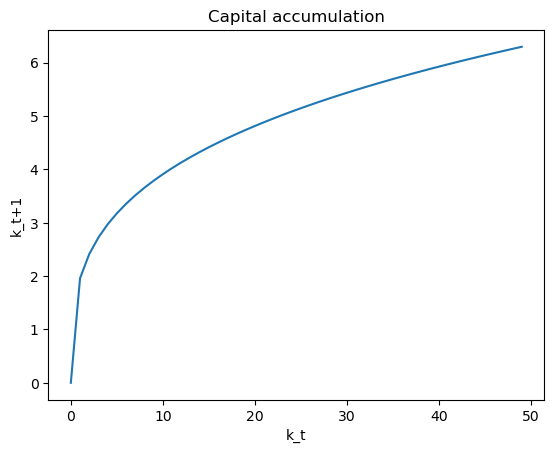

In [14]:
#Create plot
plt.plot(k_t1)
plt.title('Capital accumulation')
plt.ylabel('k_t+1')
plt.xlabel('k_t')
plt.show

In [19]:
#calulate steady state
print('steady state:')
print(Kss)

steady state:
1.9242328868855298


You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

We would like to also have done it with fully funded system, but we did not have time

# Conclusion

Add concise conclusion. 